# Beyond Markovian Models with GLMs: An Application to Zebrafish Behavior

In this tutorial you will develop a multiclass logistic regression model and apply it to measurements of larval zebrafish behavior. Larval zebrafish swim with punctuated tail flicks called "bouts." There are different types of bouts: quick movements to orient toward and converge upon prey, larger movements to quickly explore or move through an environment, and many more.  You will build a regression model to predict the next bout type given the locations of prey in the fish's field of view.  

We will use data from [Johnson et al (2019)](https://doi.org/10.1016/j.cub.2019.11.026).  The data are available for download here: https://data.mendeley.com/datasets/8sb4ywbx7f/1 (DOI: 10.17632/8sb4ywbx7f.1), and this notebook will download the necessary files to the working directory. 

![Figure 1](https://raw.githubusercontent.com/blobology/beast/master/assets/f1a.jpg)
Figure 1 of Johnson et al (2019) is reproduced here for convenience. The fish swim in a large tank and are tracked with an overhead camera (A).  Each trial begins with the fish at the center of the tank and lasts up to hundreds of seconds (B).  Swim bouts are easily detectable in the orientation time series (C), and zooming in we see that they are relatively brief compared to the interbout intervals (D).  Swim bouts typically last fewer than 10 frames or 166ms (E), and in each video frame we detect the fish's tail shape and eye angles (F).  We also identify the objects in the fish's field of view (I,J), many of which are paramecia, which the fish preys upon.

Johnson et al (2019) clustered the swim bouts into 5 major types and 18 subtypes.  They further separated bout types based on change in heading (to the left or right), for a total of 36 bout types at the finest granularity.  They then built, fit, and compared various regression models based on their ability to predict which of the 36 bout types would occur next, given many features summarizing the fish's environment and past behavior.   We will take a simpler approach, modeling only left and right versions of the 5 major types, for a total of 10 possible labels.


# Multi-class Logistic Regression Model

You will train a model to predict the bout label given _intrinsic_ features extracted from its behavioral history, as well as _extrinsic_ features like the locations of objects in the fish's field of view.  

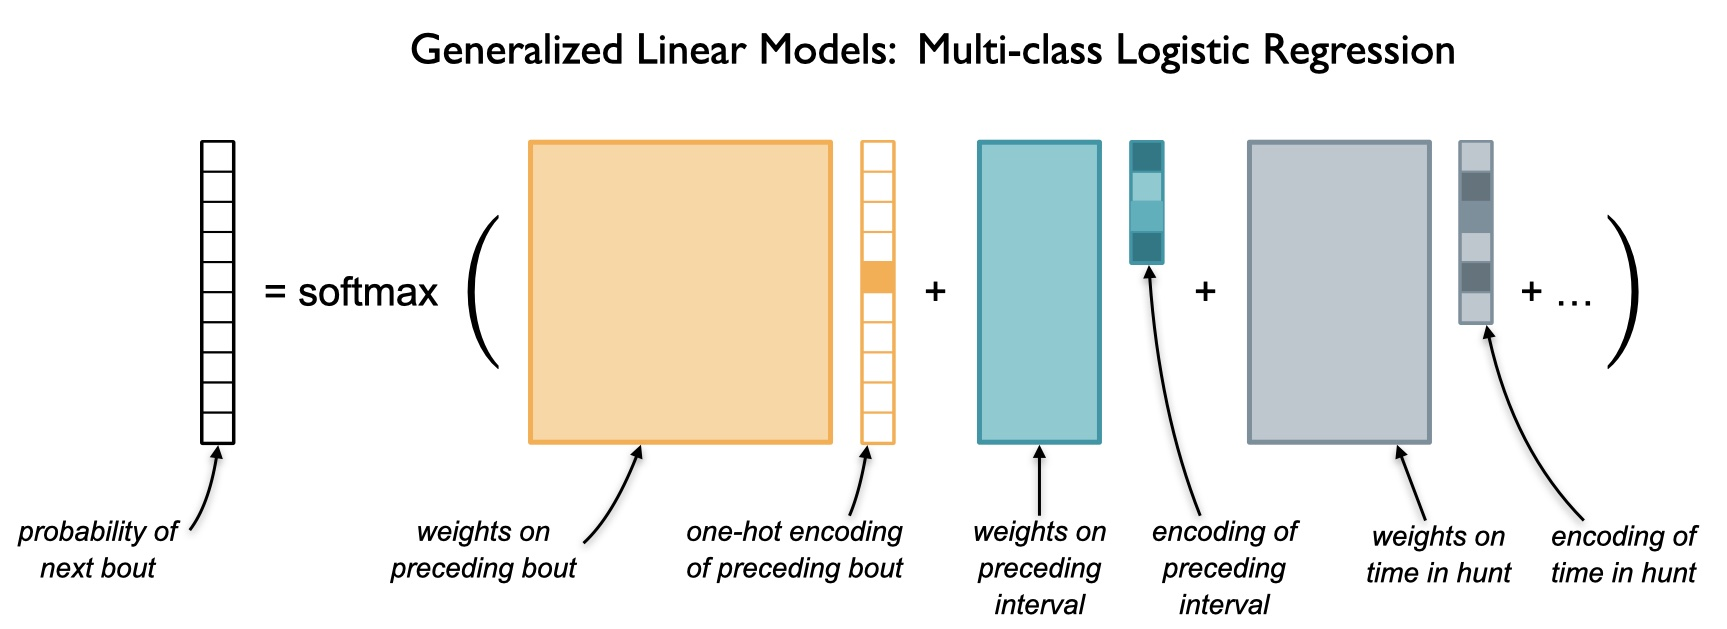

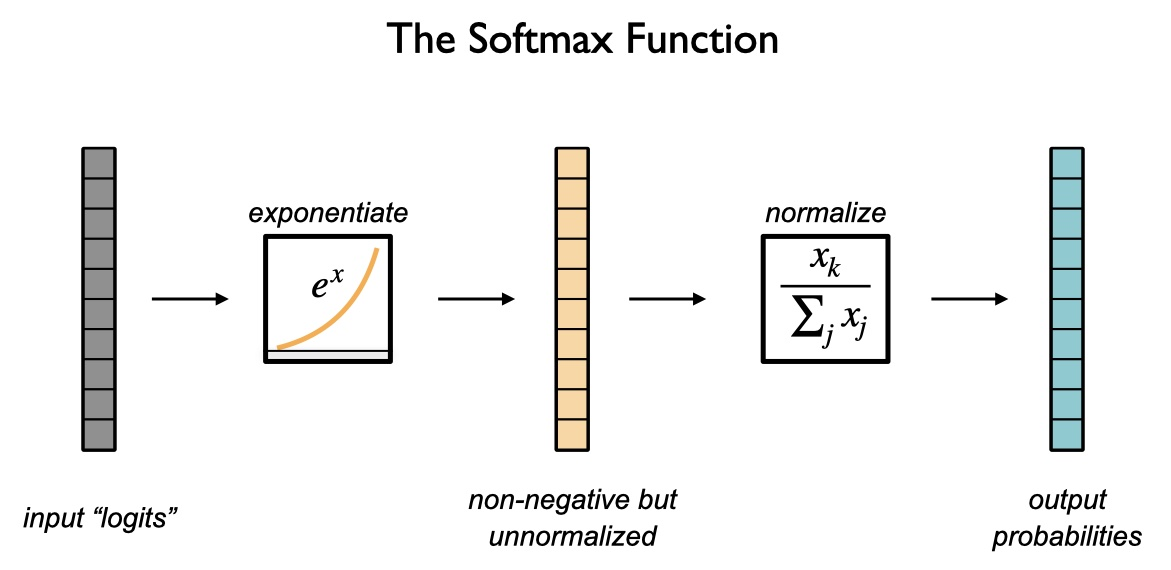

## Mathematical Formulation
Let $b_n \in \{1, \ldots, 10\}$ denote the label of the $n$-th bout. Likewise, let
- $b_{n-1} \in \{1,\ldots,10\}$ denote the label of the preceding bout
- $i_n \in \mathbb{R}_+$ denote the interval of time elapsed since the most recent bout
- $t_n^{(\mathsf{e})} \in \mathbb{R}_+$ denote the time (in number of bouts) that the fish has been exploring
- $t_n^{(\mathsf{h})} \in \mathbb{R}_+$ denote the time (in number of bouts) that the fish has been hunting
- $v_n \subset \mathbb{R}^2$ denote the set of prey locations in the fish's field of view immediately prior to bout onset.

 For the latter, the compartments tile a "Pac-Man" shaped field of view (See Fig 1J) covering an angular span of $[-\tfrac{3}{4} \pi, +\tfrac{3}{4} \pi]$ and a radial distance of approximately 4mm, or 1 fish length.  




This model is called a **multi-class logistic regression**, 
$$
\begin{align*}
p(b_n) &\propto \exp \left \{ W_b \phi_b(b_{n-1}) + W_i \phi_i(i_n) + W_e \phi_e(t_n^{(e)}) + W_h \phi_h(t_n^{(h)}) + W_v \phi_v(v_n) \right \}.
\end{align*}
$$

The weights $W_\star$ are the parameters of the model. We will learn these from the data. The functions $\phi_\star(\cdot)$ are _feature encoders_ which map each feature to a vector form. There will be hyperparameters associated with each of these, which we will simply hard code for this tutorial.



## References

Robert Evan Johnson\*, Scott Linderman\*, Thomas Panier, Caroline Lei Wee, Erin Song, Kristian Joseph Herrera, Andrew Miller, Florian Engert. _Probabilistic Models of Larval Zebrafish Behavior Reveal Structure on Many Scales_. Current Biology. 2019. https://doi.org/10.1016/j.cub.2019.11.026


# Part 0: Set up the environment
Don't change anything here.

In [ ]:
# Import necessary packages.
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
from matplotlib.cm import get_cmap
import numpy as np
import numpy.random as npr
import pickle
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tqdm

## Download the data.

In [ ]:
# If this fails, wait a moment and try running the cell again.
!wget -nc https://data.mendeley.com/datasets/8sb4ywbx7f/1/files/7e7fad4e-afb3-4f6b-bb3a-bef844894597/preyData.pkl
!wget -nc https://data.mendeley.com/datasets/8sb4ywbx7f/1/files/7b241d5e-9110-4438-970d-86b704d38974/boutData.pkl

# Load the pickled data files.
with open("boutData.pkl", "rb") as input_file:
    bout_data = pickle.load(input_file)
with open("preyData.pkl", "rb") as input_file:
    prey_data = pickle.load(input_file)

File ‘preyData.pkl’ already there; not retrieving.

File ‘boutData.pkl’ already there; not retrieving.



## Here are a few constants and helper functions.
Don't change anything here.

In [ ]:
NUM_BOUTS = len(prey_data.keys())         # number of bouts in dataset
NUM_TOTAL_BOUT_TYPES = 36                 # total number of bout types 
                                          # (major bout types * minor bout types * num directions)
NUM_MAJOR_BOUT_TYPES = 5                  # number of major bout types
NUM_MINOR_BOUT_TYPES = [10, 2, 4, 1, 1]   # number of subdivisions for each major bout type
NUM_HEADINGS = 2                          # number of heading directions

# We will encode the data in terms of major bout type and heading only.
NUM_BOUT_TYPES = NUM_MAJOR_BOUT_TYPES * NUM_HEADINGS
MAJOR_BOUT_NAMES = ["explore", "J-turn", "pursuit", "abort", "strike"]
HEADING_NAMES = ["(R)", "(L)"]
BOUT_NAMES = []
for mname in MAJOR_BOUT_NAMES:
    for hname in HEADING_NAMES:
        BOUT_NAMES.append("{} {}".format(mname, hname))

# Specify range of the Pac-Man field of view
MIN_ANGLE = -.75 * np.pi    # radians
MAX_ANGLE = .75 * np.pi     # radians
MIN_DISTANCE = 35           # a.u.
MAX_DISTANCE = 310          # a.u.

In [ ]:
#@title Helper functions (run this cell!)
def onehot(x, num_classes):
    """
    Convert a 1-d array of integers x into 2-d binary array of indicators
    """
    assert x.ndim == 1
    x_onehot = x[:, None] == np.arange(num_classes)
    assert np.all(x_onehot.sum(axis=1) == 1)
    return x_onehot


def relabel_bouts(bout_labels):
    """
    Extract the major bout type and heading from the 0...35 bout labeling
    and relabel them as 0...9 where:

        (0, 1) = explore left/right
        (2, 3) = J-turn left/right
        (4, 5) = pursuit left/right
        (6, 7) = abort left/right
        (8, 9) = strike left/right
    """
    major_bout_labels = np.zeros(NUM_BOUTS)
    major_bout_labels[(bout_labels >= 20) & 
                      (bout_labels <  24)] = 1
    major_bout_labels[(bout_labels >= 24) & 
                      (bout_labels <  32)] = 2
    major_bout_labels[(bout_labels >= 32) & 
                      (bout_labels <  34)] = 3
    major_bout_labels[(bout_labels >= 34) & 
                      (bout_labels <  36)] = 4

    heading_labels = (bout_labels % 2 == 0)

    return major_bout_labels * 2 + heading_labels


def plot_pacman(ax=None, **kwargs):
    """
    Draw the outline of the field of view.
    """
    ax = ax if ax is not None else plt.gca()
    thetas = np.linspace(MIN_ANGLE, MAX_ANGLE, 100)
    plt.plot(np.cos(thetas) * MIN_DISTANCE, 
             np.sin(thetas) * MIN_DISTANCE,
             '-k', **kwargs)
    plt.plot(np.cos(MIN_ANGLE) * np.array([MIN_DISTANCE, MAX_DISTANCE]),
             np.sin(MIN_ANGLE) * np.array([MIN_DISTANCE, MAX_DISTANCE]),
             '-k', **kwargs)
    plt.plot(np.cos(thetas) * MAX_DISTANCE, 
             np.sin(thetas) * MAX_DISTANCE,
             '-k', **kwargs)
    plt.plot(np.cos(MAX_ANGLE) * np.array([MIN_DISTANCE, MAX_DISTANCE]),
             np.sin(MAX_ANGLE) * np.array([MIN_DISTANCE, MAX_DISTANCE]),
             '-k', **kwargs)
    

def plot_environment(bout_number, prey_data, scale=6, ax=None):
    """
    Plot the locations, sizes, headings, and eccentricities of the objects in
    the field of view for a given bout number.
    """
    ax = ax if ax is not None else plt.gca()
    ax.set_aspect("equal")
    ax.set_axis_off()

    # Plot the bounding box
    plot_pacman(ax=ax)

    # Make an ellipse for each prey object
    ellipses = []
    for i in range(prey_data[bout_number]["numObjects"]):
        # Get details of i-th prey object
        yx = prey_data[bout_number]["location"][i]
        area = prey_data[bout_number]["area"][i]
        eccentricity = prey_data[bout_number]["eccentricity"][i]
        orientation = prey_data[bout_number]["orientation"][i]

        # Convert eccentricity/area to width/height
        R = (1 - (eccentricity ** 2)) ** .5
        height = ((R * area * scale) / np.pi) ** .5
        width = height / R
        angle = orientation * 180 / np.pi
        ellipses.append(Ellipse(xy=yx[::-1],
                                width=width, 
                                height=height, 
                                angle=angle))

    for e in ellipses:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(1)
        e.set_facecolor('k')


def make_grid(num_angular_bins, num_distance_bins):
    """
    Make arrays of angular and distance bin edges.
    """
    angular_bins = np.linspace(MIN_ANGLE, MAX_ANGLE, num_angular_bins + 1)
    distance_bins = np.linspace(MIN_DISTANCE, MAX_DISTANCE, num_distance_bins + 1)
    return (angular_bins, distance_bins)


def _make_compartment(dist_start, dist_stop, ang_start, ang_stop, color):
    """
    Make a polygon for a single compartment of the Pac-Man field of view.
    """
    # Build the envelope
    xenv = []
    yenv = []
    # Lower left
    xenv.append([dist_start * np.cos(ang_start)])
    yenv.append([dist_start * np.sin(ang_start)])
    # Upper left to upper right
    xenv.append(dist_stop * np.cos(np.linspace(ang_start, ang_stop)))
    yenv.append(dist_stop * np.sin(np.linspace(ang_start, ang_stop)))
    # Lower right to lower left
    xenv.append(dist_start * np.cos(np.linspace(ang_stop, ang_start)))
    yenv.append(dist_start * np.sin(np.linspace(ang_stop, ang_start)))

    env = np.column_stack((np.concatenate(xenv), np.concatenate(yenv)))
    return Polygon(env, color=color, linewidth=0)


def plot_weights(weights, grid, 
                 cmap="RdBu_r", ax=None, title=None, 
                 w_min=None, w_max=None,
                 linewidth=2):
    """
    Plot a set of weights for each compartment of the field of view.
    """
    ax = ax if ax is not None else plt.gca()
    cmap = get_cmap(cmap)
    
    # Extract the bin edges from the grid
    angular_bins, distance_bins = grid

    # Check that weights are consistent with the given bins
    assert weights.shape == (len(angular_bins) - 1, len(distance_bins) - 1)
    if w_min is None or w_max is None:
        w_max = max(np.max(abs(weights)), 1e-16)
        w_min = -w_max
    normalize = lambda w: (w - w_min) / (w_max - w_min)

    # Plot the spatial grid
    thetas = np.linspace(angular_bins[0], angular_bins[-1], 100)
    for d in distance_bins:
        ax.plot(d * np.cos(thetas),
                d * np.sin(thetas),
                '-k', lw=linewidth)
    for a in angular_bins:
        ax.plot([distance_bins[0] * np.cos(a), distance_bins[-1] * np.cos(a)],
                [distance_bins[0] * np.sin(a), distance_bins[-1] * np.sin(a)],
                '-k', lw=linewidth)

    # Plot polygons for each cell
    for i in range(len(angular_bins) - 1):
        for j in range(len(distance_bins) - 1):
            ang_start, ang_stop = angular_bins[i], angular_bins[i+1]
            dist_start, dist_stop = distance_bins[j], distance_bins[j+1]
            color = cmap(normalize(weights[i, j]))
            poly = _make_compartment(dist_start, dist_stop, 
                                     ang_start, ang_stop, color)
            ax.add_patch(poly)

    if title is not None:
        ax.set_title(title)
    ax.set_aspect(1.0)
    ax.set_axis_off()


def bin_prey_locations(grid):
    """
    Count the number of objects in each compartment. Do this for all bouts.
    """
    # Extract the bin edges from the grid
    angular_bins, distance_bins = grid

    # Initialize array of prey counts
    prey_counts = np.zeros((NUM_BOUTS, 
                           len(angular_bins) - 1, 
                           len(distance_bins) - 1))
    
    # Iterate over each bout and bin the prey
    for n in tqdm.trange(NUM_BOUTS):
        if prey_data[n]["numObjects"] > 0:
            yx_locs = prey_data[n]["location"]
            distances = np.linalg.norm(yx_locs, axis=1)
            angles = np.arctan2(yx_locs[:, 0], yx_locs[:, 1])
            hist, _, _ = np.histogram2d(angles, distances, 
                                        (angular_bins, distance_bins))
            prey_counts[n] = hist
    
    return prey_counts


def normalize_by_bin_area(prey_counts, grid):
    """
    Bins at farther distances have larger area.  The area of a bin that spans 
    dtheta radians and the interval [r, r+dr) in the radial dimension is equal
    to (r dtheta dr + 0.5 * dtheta * dr**2). 

    First normalize the prey counts to make them densities, then standardize
    the densities so they are mean zero and standard deviation 1. 
    """
    # Extract the bin edges from the grid
    angular_bins, distance_bins = grid
    
    # Compute the area of bins at distance r from the fish
    dtheta = angular_bins[1] - angular_bins[0]
    dr = distance_bins[1] - distance_bins[0]
    bin_areas = distance_bins[:-1] * dtheta * dr + 0.5 * dtheta * dr**2

    # Scale the areas to be in units of the area of the smallest bin
    bin_areas /= bin_areas[0]

    # Normalize the prey counts and standardize 
    return prey_counts / bin_areas


def encode_temporal_basis(x, n_basis, tmin=0, tmax=1.0):
    std = (tmax - tmin) / n_basis
    means = np.linspace(tmin, tmax, n_basis)

    # make a basis to return as well
    t_basis = np.linspace(tmin, tmax, 1000)
    basis = np.stack([
        np.exp(-0.5 * (t_basis - m)**2 / std**2)
        for m in means])

    # Encode by linearly interpolating
    valid = (x > tmin) & (x < tmax)
    encoded_x = np.column_stack([
        np.exp(-0.5 * (x - m)**2 / std**2) * valid
        for m in means
    ]) 
    return encoded_x, (t_basis, basis)

def extract_hunt_explore_time(bout_data):
    # Extract time in hunt (in units of bouts)
    targets = relabel_bouts(bout_data['boutLabel'])
    is_explore = targets < 2
    
    # Find changes in state (hunt vs explore) and in sequence num
    is_change = np.concatenate([[True], np.diff(bout_data['uniqueSeqNum']) != 0])
    
    explore_time = np.zeros_like(targets)
    hunt_time = np.zeros_like(targets)
    explore_counter = 0
    hunt_counter = 0
    for t in range(1, NUM_BOUTS):
        if is_change[t]:
            explore_counter = 0
            hunt_counter = 0

        explore_time[t] = explore_counter
        hunt_time[t] = hunt_counter
        
        if is_explore[t]:
            explore_counter += 1
            hunt_counter = 0
        else:
            hunt_counter += 1
            explore_counter = 0

    return explore_time, hunt_time


def compute_log_prob(model, X_test, y_test):
    lps = model.predict_log_proba(X_test)
    return lps[np.arange(len(y_test)), y_test.astype(int)].mean()


# Part 1: Exploratory Analysis
Before starting, let's look at some data. First, let's see what keys are in the `bout_data` dictionary

In [ ]:
bout_data.keys()

dict_keys(['boutLabel', 'precedingInterval', 'followingInterval', 'boutDuration', 'deltaHeading', 'deltaPosition', 'tSNE', 'fishNum', 'trialNum', 'subtrialNum', 'uniqueSeqNum', 'fed', 'tankTime'])

## Zero-th order analysis
Make a histogram of different bout types.

Text(0, 0.5, 'number of bouts')

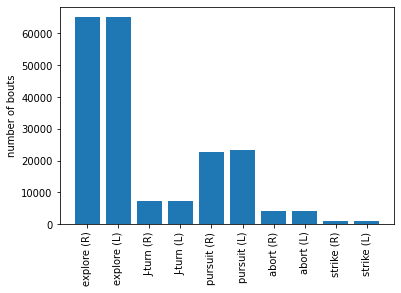

In [ ]:
# Plot the overall bout type usage
bout_labels = relabel_bouts(bout_data["boutLabel"]).astype(int)
plt.bar(np.arange(NUM_BOUT_TYPES), np.bincount(bout_labels))
plt.xticks(np.arange(NUM_BOUT_TYPES), BOUT_NAMES, rotation=90)
plt.ylabel("number of bouts")

## Exercise 1.1: First order analysis
Make a transition matrix and visualize it with `imshow`.

In [ ]:
# NUM_BOUTS
# # bout_labels[1000:1010]

array([1, 3, 5, 7, 1, 0, 0, 0, 2, 5])

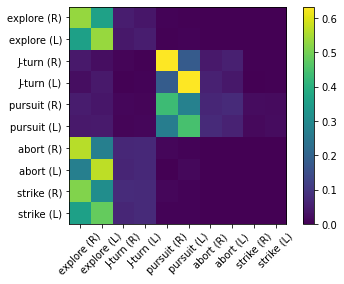

In [ ]:
## 
# YOUR CODE HERE
#
# HINT: you should be using bout_labels
transition_matrix = np.zeros((NUM_BOUT_TYPES, NUM_BOUT_TYPES))
for t in range(NUM_BOUTS-1):
    i = bout_labels[t]
    j = bout_labels[t+1]
    transition_matrix[i, j] += 1

transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
# ...
#
##

plt.imshow(transition_matrix)
plt.xticks(np.arange(NUM_BOUT_TYPES), BOUT_NAMES, rotation=45)
plt.yticks(np.arange(NUM_BOUT_TYPES), BOUT_NAMES)
plt.colorbar()

## Plot a distribution of inter-bout intervals 

Text(0, 0.5, 'count')

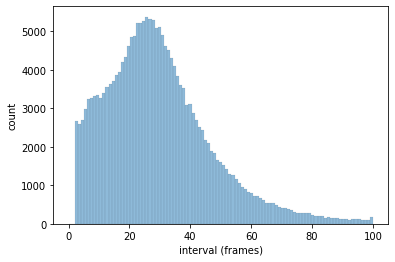

In [ ]:
plt.hist(bout_data['precedingInterval'], np.linspace(0, 100, 100),
         alpha=0.5, ec='k', lw=0.1)
plt.xlabel("interval (frames)")
plt.ylabel("count")

## Plot the paramecia in the fish's field of view
`prey_data` is a dictionary where each key is a bout index and each value is another dictionary. For example, the dictionary for bout 8720 contains the location, etc. of paramecia in the fish's field of view preceding that bout.

In [ ]:
prey_data[8720].keys()

dict_keys(['numObjects', 'area', 'eccentricity', 'orientation', 'location', 'velocity'])

We've written a helper function to take `prey_data` dict and plot the field of view.

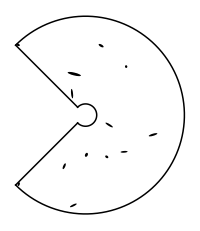

In [ ]:
bout_id = 8720
plot_environment(bout_id, prey_data)

# Part 2: Preprocess the data to extract possible features and targets
Don't change anything here.

In [ ]:
# The targets are the bout labels. Each is an integer (1,...,10).
# We'll store the encoded features in a dictionary
targets = relabel_bouts(bout_data["boutLabel"])
features = dict()

## Encode the previous bout with a one-hot vector

Text(0, 0.5, 'bout index')

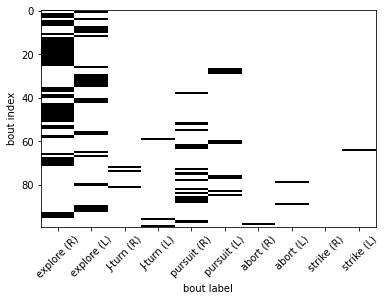

In [ ]:
# Get the preceding bout
# (Note: this is a bit hacky but it works for our purpose.)
prev_bout_label = np.concatenate([[0], targets[:-1]])
features['$b_{n-1}$'] = onehot(prev_bout_label, NUM_BOUT_TYPES)

# Plot the feature encoding first hundred bouts
plt.imshow(features["$b_{n-1}$"][:100], aspect="auto", interpolation="none", cmap="Greys")
plt.xlabel("bout label")
plt.xticks(np.arange(NUM_BOUT_TYPES), BOUT_NAMES, rotation=45)
plt.ylabel("bout index")

## Question 2.1
_Why do we encode the previous bout as a one-hot vector rather than giving the GLM the integer label directly?_

## Encode the preceding inter-bout interval with a collection of basis functions

Text(0, 0.5, 'encoding')

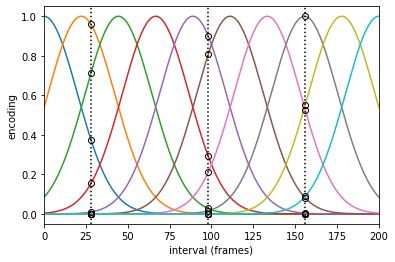

In [ ]:
# Encode the time elapsed since preceding bout
features['$i_{n}$'], (intvl_times, intvl_basis) = encode_temporal_basis(bout_data['precedingInterval'], 10, tmax=200)

# Plot the basis and the encoding for a few intervals
plt.plot(intvl_times, intvl_basis.T)
for i in [0, 20, 30]:
    intvl = bout_data['precedingInterval'][i]
    encoding = features['$i_{n}$'][i]
    plt.axvline(intvl, ls=':', color='k')
    plt.plot(intvl * np.ones(10), encoding, 'ko', mfc='none')
plt.xlim(0, 200)
plt.xlabel("interval (frames)")
plt.ylabel("encoding")

(0.0, 100.0)

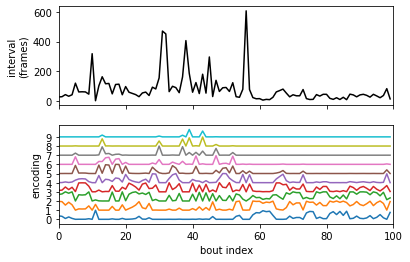

In [ ]:
# Plot the interval encoding in a another way
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(bout_data['precedingInterval'][:100], '-k')
axs[0].set_ylabel("interval\n(frames)")
axs[1].plot(features['$i_{n}$'][:100] + np.arange(10))
axs[1].set_yticks(np.arange(10))
axs[1].set_ylabel("encoding")
axs[1].set_xlabel("bout index")
axs[1].set_xlim(0, 100)

## Question 2.2
_What do we gain by encoding the preceding interval in this way? Why not just give the GLM the raw interval?_

## Encode the time in explore/hunt with a collection of basis functions


(0.0, 100.0)

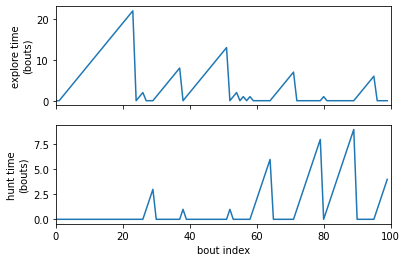

In [ ]:
# Get time in explore or hunt state
n_prec_explore_bouts, n_prec_hunt_bouts = extract_hunt_explore_time(bout_data)
features['$t_{\mathrm{explore}}$'], (explore_times, explore_basis) = encode_temporal_basis(n_prec_explore_bouts, 10, tmax=100)
features['$t_{\mathrm{hunt}}$'], (hunt_times, hunt_basis) = encode_temporal_basis(n_prec_hunt_bouts, 10, tmax=70)

# Plot the number of preceding hunt or explore bouts
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(n_prec_explore_bouts[:100])
axs[0].set_ylabel("explore time\n(bouts)")
axs[1].plot(n_prec_hunt_bouts[:100])
axs[1].set_ylabel("hunt time\n(bouts)")
axs[1].set_xlabel("bout index")
axs[1].set_xlim(0, 100)

## Question 2.3 
_Why might time in the "hunt" or "explore" states be predictive of future behavior?_

## Encode the locations of prey in the fish's field of view
This takes a little bit of time since it involves iterating over a dict of dicts.

100%|██████████| 200559/200559 [00:22<00:00, 8796.53it/s]


Text(0.5, 1.0, 'Bout 8720 Prey Objects and Density')

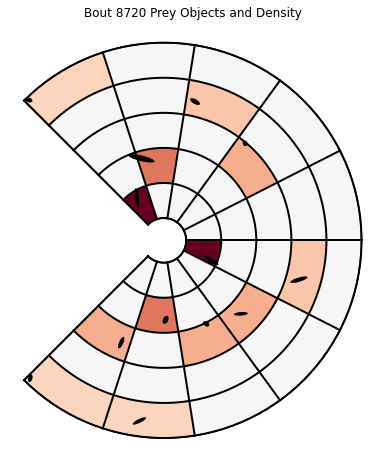

In [ ]:
# Start with a grid of 10 angular and 5 distance bins.
NUM_ANGULAR_BINS = 10
NUM_DISTANCE_BINS = 5
grid = make_grid(NUM_ANGULAR_BINS, NUM_DISTANCE_BINS)

# Count the number of prey objects in each bin for each bout.
prey_counts = bin_prey_locations(grid)
features['$v_{loc}$'] = normalize_by_bin_area(prey_counts, grid).reshape(-1, NUM_ANGULAR_BINS * NUM_DISTANCE_BINS)

# Plot the weights for one frame
plt.figure(figsize=(8, 8))
plot_environment(8720, prey_data)
plot_weights(features['$v_{loc}$'][8720].reshape(NUM_ANGULAR_BINS, NUM_DISTANCE_BINS), grid)
plt.title("Bout 8720 Prey Objects and Density")

## Question 2.4
_This encoding captures prey density. What other features of the prey might be informative?_

## Question 2.5
_How do these features introduce non-Markovian dependencies? Why don't we just explicitly include the past bouts ($b_{n-\ell}$ for $\ell > 1$) as covariates?_ 

# Part 3: Let's fit some models!

Start by splitting the data into train and test sets.

In [ ]:
# Split the data into 80% train and 20% test sets.
npr.seed(0)
train_indices = npr.rand(NUM_BOUTS) < 0.80
test_indices = ~train_indices
n_train = train_indices.sum()
n_test = test_indices.sum()

We'll fit a bunch of models with different subsets of features. We'll store the fitted models in a dictionary, as well as the log probability those models assign to held out data.

In [ ]:
models = dict()
logprobs = dict()

## Dummy model
Our first model is a "dummy." It just assigns a constant probability to each bout type according to its frequency in the training set. You can do this in scikit-learn using the `DummyClassifier`.

In [ ]:
# Fit a dummy model
dummy = DummyClassifier(strategy="prior")
dummy.fit(np.zeros((n_train, 1)), targets[train_indices])
models['dummy'] = dummy
logprobs['dummy'] = compute_log_prob(dummy, np.zeros((n_test, 1)), targets[test_indices])

## Helper function to fit and evaluate a model

In [ ]:
def fit_model(X, y):
    # model = make_pipeline(PCA(X.shape[1]), LogisticRegression(fit_intercept=False))
    model = LogisticRegression(fit_intercept=False)
    model.fit(X[train_indices], y[train_indices])
    lp = compute_log_prob(model, X[test_indices], y[test_indices])
    return model, lp 

## Fit a sequence of models, adding in one feature at a time

This code block adds in one feature at a time to construct a richer and richer model. Each model is evaluated based on the log probability it assigns to held-out data.

**Note: This cell will take a few minutes. Get up and stretch!**

In [ ]:
feature_names = ['$b_{n-1}$',               # preceding bout label
                 '$i_{n}$',                 # preceding interval
                 '$v_{loc}$',               # locations of paramecia
                 '$t_{\mathrm{explore}}$',  # time in explore state
                 '$t_{\mathrm{hunt}}$'      # time in hunt state
                 ]

for i in range(1, len(feature_names)+1):
    model_name = '(' + ', '.join(feature_names[:i]) + ')'
    print("")
    print("Fitting model with features:")
    print(model_name)

    X = np.column_stack([features[name] for name in feature_names[:i]]).astype(float)
    y = targets.astype(int)
    models[model_name], logprobs[model_name] = fit_model(X, y) 


Fitting model with features:
($b_{n-1}$)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Fitting model with features:
($b_{n-1}$, $i_{n}$)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Fitting model with features:
($b_{n-1}$, $i_{n}$, $v_{loc}$)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Fitting model with features:
($b_{n-1}$, $i_{n}$, $v_{loc}$, $t_{\mathrm{explore}}$)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Fitting model with features:
($b_{n-1}$, $i_{n}$, $v_{loc}$, $t_{\mathrm{explore}}$, $t_{\mathrm{hunt}}$)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Make a bar plot of improvement over baseline

We plot the difference in log probability between the fitted model and the dummy model, normalized by the number of bouts. Since log probabilities are measured in _nats_, the units are _nats/bout_.

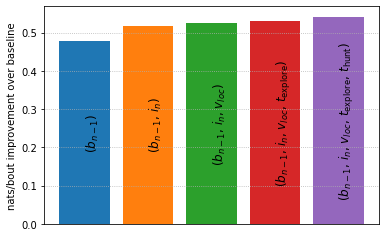

In [ ]:
for i in range(1, len(feature_names) + 1):
    model_name = '(' + ', '.join(feature_names[:i]) + ')'
    height = logprobs[model_name] - logprobs['dummy']
    plt.bar(i - 1, height) 
    plt.text(i - 1, height / 2, model_name, rotation=90, fontsize=12, verticalalignment='center')

plt.ylabel("nats/bout improvement over baseline")
plt.xticks([])
plt.grid(True, ls=':')

## Question 3.1
_Does this plot tell you which feature is most predictive? If so, explain why. If not, what does it tell you?_

## Question 3.2
_What does an increase of 0.05 nats/bout say about the relative probability one model assigns to the data vs another?_

## Exercise 3.3: Plot a transition matrix with the previous-bout-only model
Plot the inferred transition matrix estimated by the model with only the preceding bout ($b_{n-1}$).


In [ ]:
model.coef_.shape

(10, 10)

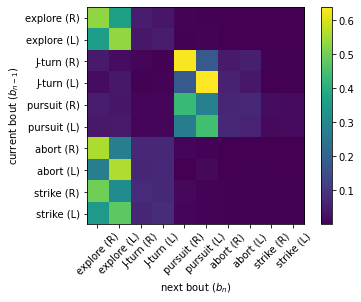

In [ ]:
model = models["($b_{n-1}$)"]

##
# YOUR CODE HERE
#
transition_matrix = np.exp(model.coef_.T)
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
#
##

# Plot the transition matrix
plt.imshow(transition_matrix)
plt.xticks(np.arange(NUM_BOUT_TYPES), BOUT_NAMES, rotation=45)
plt.xlabel("next bout ($b_n$)")
plt.yticks(np.arange(NUM_BOUT_TYPES), BOUT_NAMES)
plt.ylabel("current bout ($b_{n-1}$)")
plt.colorbar()

## Extract the weights from the full model

In [ ]:
full_model = models["(" + ", ".join(feature_names) + ")"]
prev_bout_weights = full_model.coef_[:, :10]
intvl_weights = full_model.coef_[:, 10:20]
prey_weights = full_model.coef_[:, 20:70].reshape(NUM_BOUT_TYPES, NUM_ANGULAR_BINS, NUM_DISTANCE_BINS)
explore_weights = full_model.coef_[:, 70:80]
hunt_weights = full_model.coef_[:, 80:90]

## Exercise 3.4: Now plot the transition matrix with the full model

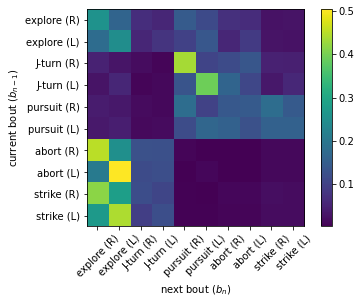

In [ ]:
##
# YOUR CODE HERE
#
transition_matrix = np.exp(prev_bout_weights.T)
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
#
##

# Plot the transition matrix
plt.imshow(transition_matrix)
plt.xticks(np.arange(NUM_BOUT_TYPES), BOUT_NAMES, rotation=45)
plt.xlabel("next bout ($b_n$)")
plt.yticks(np.arange(NUM_BOUT_TYPES), BOUT_NAMES)
plt.ylabel("current bout ($b_{n-1}$)")
plt.colorbar()

## Quesetion 3.5
Why does this "transition matrix" look different in the full model?

## Plot the weights on preceding intervals



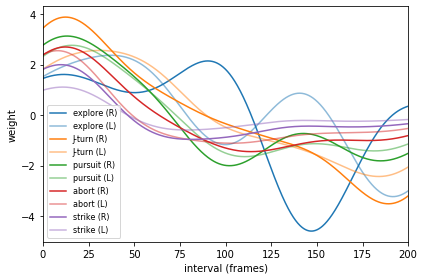

In [ ]:
for i in range(5):
    ln = plt.plot(intvl_times, intvl_weights[:, i*2] @ intvl_basis, 
                     label=BOUT_NAMES[i*2])[0]
    plt.plot(intvl_times, intvl_weights[:, i*2+1] @ intvl_basis, 
                label=BOUT_NAMES[i*2+1],
                color=ln.get_color(), alpha=0.5)
    plt.legend(fontsize=8)
    plt.ylabel("weight")
    
plt.xlabel("interval (frames)")
plt.xlim(0, 200)
plt.tight_layout()

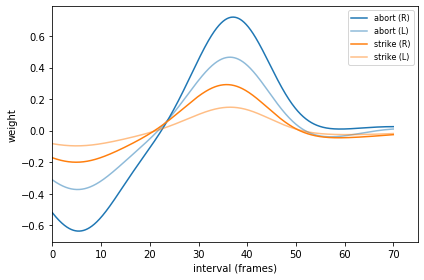

In [ ]:
for i in range(3, 5):
    ln = plt.plot(hunt_times, hunt_weights[:, i*2] @ hunt_basis, 
                  label=BOUT_NAMES[i*2])[0]
    plt.plot(hunt_times, hunt_weights[:, i*2+1] @ hunt_basis, 
             label=BOUT_NAMES[i*2+1],
             color=ln.get_color(), alpha=0.5)
    plt.legend(fontsize=8)
    plt.ylabel("weight")
    
plt.xlabel("interval (frames)")
plt.xlim(0, 75)
plt.tight_layout()

## Plot the weights on prey location for each bout type


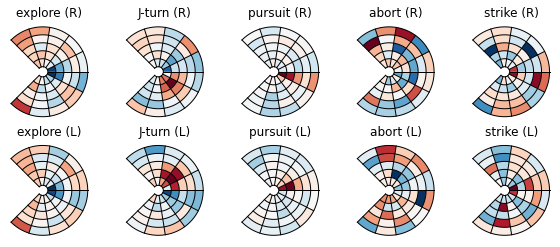

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        plot_weights(prey_weights[j*2+i], grid, ax=axs[i,j], linewidth=1)
        axs[i,j].set_title(BOUT_NAMES[j*2+i])

## Question 3.6
_Why might some "heat maps" appear noisier than others? How could you change the model to counteract this tendency?_

# Conclusion

This notebook showed how to fit and analyze a generalized linear model (GLM) for predicting syllables given not only the most recent syllable (i.e. the Markovian model), but also _intrinsic_ features of the past behavior and _extrinsic_ features of the environment. Let's end with a few discussion points.

- You may have been surprised that the prey locations were not very strong predictors. Clearly these fish are influenced by their environment. So why might the prey locations not be very predictive of the upcoming bout? 

- We didn't talk much about hyperparameters. Which hyperparameters do you think would be most important. How would you set them?

- What other features could you imagine adding to this model?

- Suppose we use a MoSeq (a hidden _Markov_ model) to find syllables. Does it make sense to subsequently model the syllables using a _non-Markovian_ model like those shown here? Or do we need to fit a non-Markovian model from the start?